In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

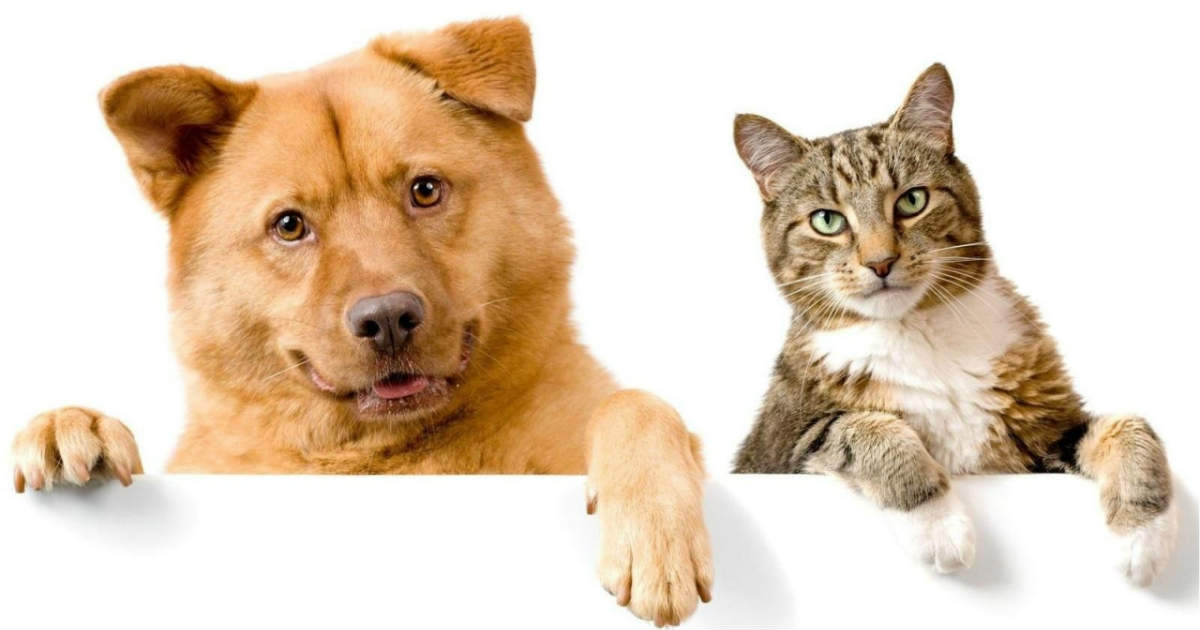

In [18]:
model_builder = keras.applications.xception.Xception
img_size = (299,299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'block14_sepconv2_act'

#下載圖片
img_path = keras.utils.get_file('cat_and_dog.jpg','https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg')

display(Image(img_path))

In [24]:
def get_img_array(img_path, size):
  img = keras.utils.load_img(img_path, target_size=size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]
  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

1/1 [==============================] - 2s 2s/step
Predicted: [('n02112137', 'chow', 4.611242)]


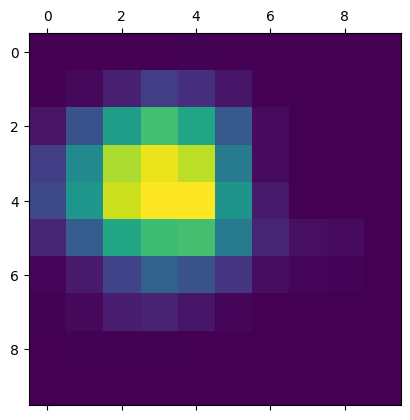

In [25]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

model = model_builder(weights="imagenet")

model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

<ipython-input-26-34cb0038ef18>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


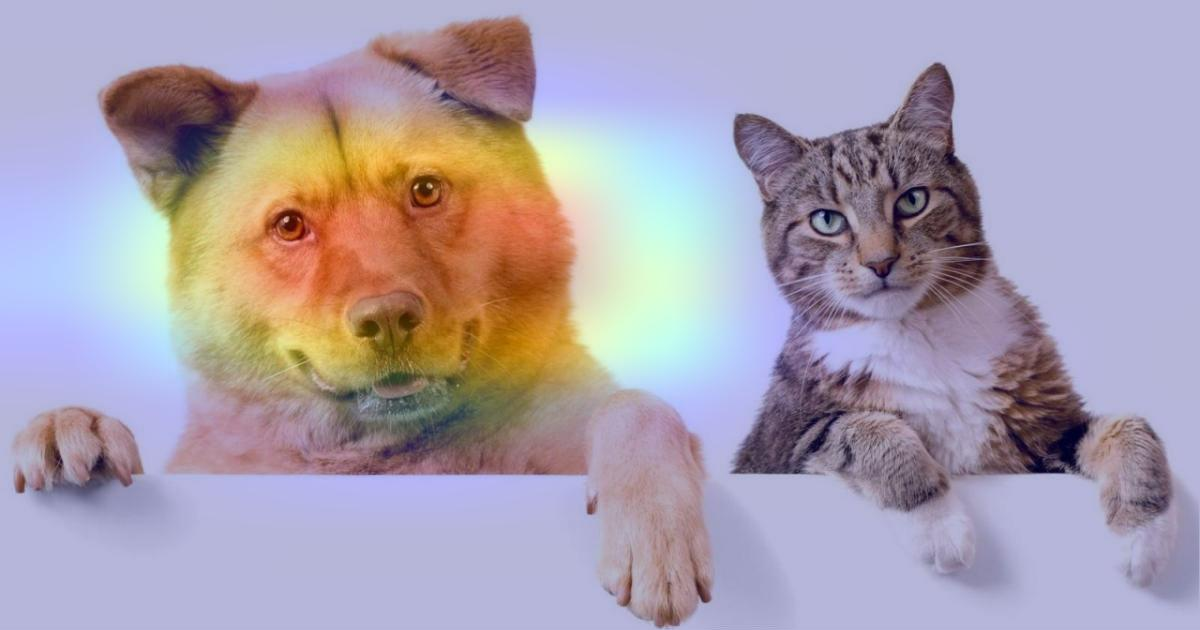

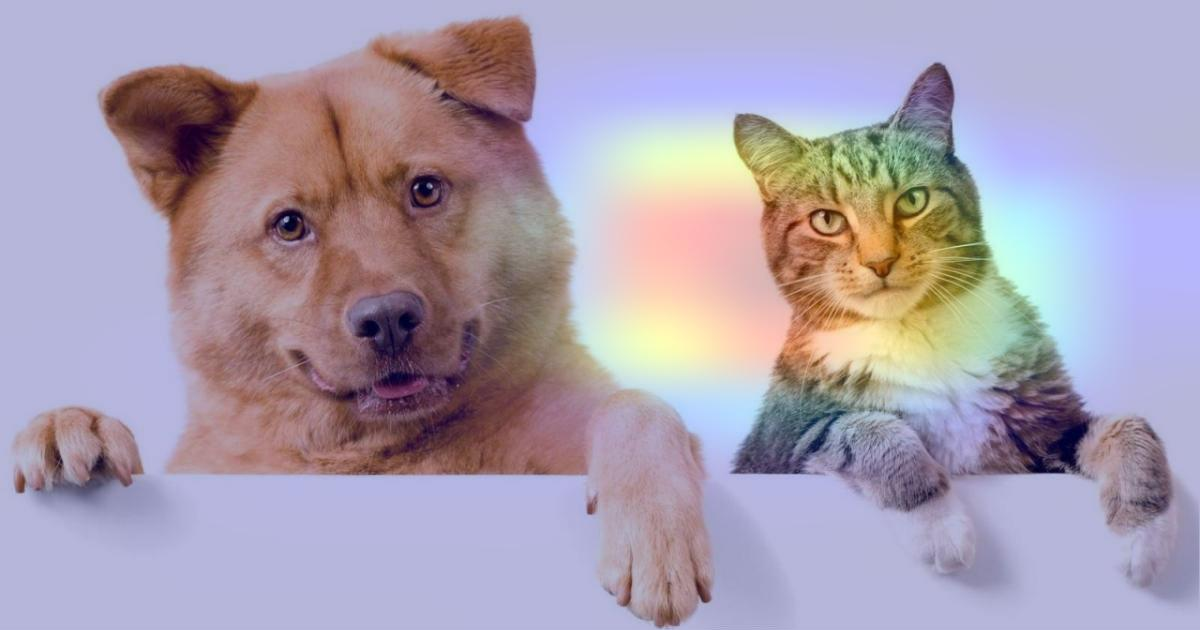

In [26]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
  img = keras.utils.load_img(img_path)
  img = keras.utils.img_to_array(img)
  heatmap = np.uint8(255 * heatmap)
  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  superimposed_img.save(cam_path)
  display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)
save_and_display_gradcam(img_path, heatmap)